# Projet Data Mining

### Description du problème

Le jeu de données Splice concerne les jonctions d'épissage. 

Un exon est un segment d'ADN conservé dans le brin résultant après épissage. Un Intron est une section d'ADN qui a été fusionnée et qui n'est pas incluse dans la séquence d'ADN résultante. Le problème de la reconnaissance de telles zones peut être divisé en 2 parties : - reconnaissance des frontières exon/intron (EI -sites) - les soi-disant donneurs -reconnaissance des limites intron/exon (sites IE) - les soi-disant accepteurs.
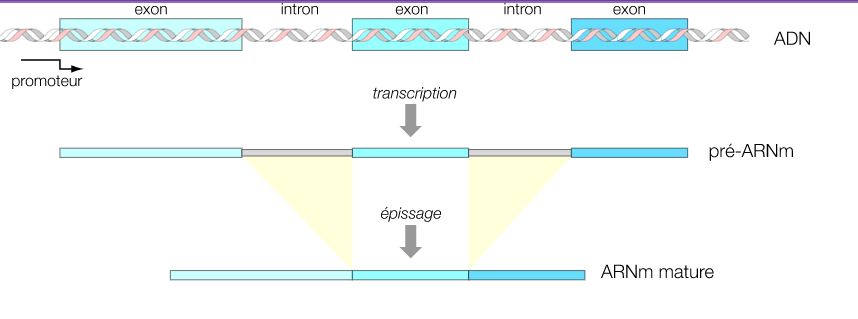
le jeu de données contient des segments d'ADN d'une longueur de 60 nucléotides, commençant par -30 et se terminant par +30 ; chaque champ de cette chaîne peut être renseigné : 
- Nucléotide explicitement indiqué (Adénine - A, Thymine - T, Guanine - G, Cytosine - C) 
- Un nucléotide implicitement spécifié: D : A ou G ou T, N : A ou G ou C ou T, S : C ou G et R : A ou G

les échantillons appartiennent à l'une des trois classes : 
- « EI » (jonction exon-intron) qui contient la jonction exon-intron 
- « IE » (jonction Intron-Exon) qui contient la jonction intron-exon 
- "N" (Ni EI ni IE) qui ne contient aucune jonction d'épissage

Charger les bibliothèques que nous utiliserons plus tard pour le traitement des données

In [2]:
import sys
print(sys.path)

['C:\\Users\\hp\\Downloads', 'C:\\Users\\hp\\anaconda3\\python38.zip', 'C:\\Users\\hp\\anaconda3\\DLLs', 'C:\\Users\\hp\\anaconda3\\lib', 'C:\\Users\\hp\\anaconda3', '', 'C:\\Users\\hp\\AppData\\Roaming\\Python\\Python38\\site-packages', 'C:\\Users\\hp\\anaconda3\\lib\\site-packages', 'C:\\Users\\hp\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg', 'C:\\Users\\hp\\anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\hp\\anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\hp\\anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\hp\\anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\hp\\.ipython']


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'
data = pd.read_csv(r'C:\Users\hp\Downloads\splice.csv', sep = ', ', engine = 'python')

Les données contiennent en fait 62 attributs :
- Classe (accepteur, donneur, non épissable),
- Nom du gène
- Séquence de 60 nucléotides

In [5]:
data

,Class,Donor,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGT...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGT...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGT...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTA...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGA...
...,...,...,...
3185,N,ORAHBPSBD-NEG-2881,TCTCTTCCCTTCCCCTCTCTCTTTCTTTCTTTTC...
3186,N,ORAINVOL-NEG-2161,GAGCTCCCAGAGCAGCAAGAGGGCCAGCTGAAG...
3187,N,ORARGIT-NEG-241,TCTCGGGGGCGGCCGGCGCGGCGGGGAGCGG...
3188,N,TARHBB-NEG-541,ATTCTACTTAGTAAACATAATTTCTTGTGC...


Pour la frontière exon-intron, il existe 2 possibilités pour déterminer la zone de raccordement:
- Option 1: EI - frontière - déterminée par une séquence courte et l'absence d'un codon stop (triplet stop) du côté de l'exon
    
	EI :- @-3 'MAGGTRAGT', not(EI-stop)  

- Option 2: EI - la frontière est construite sur la base d'un codon stop à proximité de la fin d'une partie de l'exon 
    
	EI-stop ::- @-3 'TAA'.      
	EI-stop ::- @-3 'TAG'.      
	EI-stop ::- @-3 'TGA'.      
	EI-stop ::- @-4 'TAA'.  
    EI-stop ::- @-4 'TAG'.      
    EI-stop ::- @-4 'TGA'.      
    EI-stop ::- @-5 'TAA'.      
    EI-stop ::- @-5 'TAG'.      
    EI-stop ::- @-5 'TGA'.
   

Préparons un ensemble de nucléotides 

In [8]:
nucleotids =['A','T','G','C','D','N','R','S']
for i in nucleotids:
    data[i]=0

Indiquons le nombre de nucléotides de chaque type pour chaque brin d'ADN :

In [9]:
for i in range(len(data)):
    for nc in nucleotids:
        data[nc][i] = data['DNA'][i].count(nc)

Déterminons quel codon stop est utilisé dans cette séquence, étant donné :

- Si la classe = n, pas de codon stop
- Sinon, on recherche un codon stop (on tiendra compte du fait que le voisinage du point de fusion est de 5 nucléotides, donc le codon stop ne peut pas être situé aux positions +30 ou -30)

Les règles de détermination du codon stop à la frontière de la région d'épissage indiquent qu'il peut prendre 3 valeurs différentes :

     triplet Timin-Adanin-Adanin
     triplet thymine-adénine-guanine
     triplet thymine-guanine-adénine
   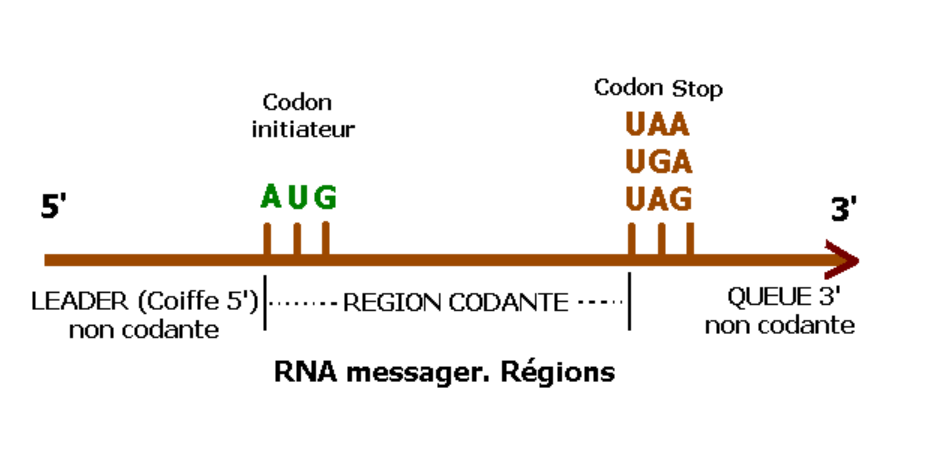
De plus, une section d'ADN, quel que soit son type, peut ne pas avoir de codon stop.

In [10]:
stop_codones = ['TAA', 'TAG', 'TGA']
data['stop-code']='None'
for i in range(len(data)):
    if data['Type'][i]!= 'N':
        for j in range(len(stop_codones)): 
            stopcd = data['DNA'][i].find(stop_codones[j], 5, 59-5 )
            if stopcd != -1:
                if data['Type'][i]!='IE':
                    data['stop-code'][i]= stop_codones[j]
                    break;
                else:
                    priamidin = stopcd-15
                    pmd_start = min(data['DNA'][i].find('T', priamidin, stopcd), data['DNA'][i].find('C', priamidin, stopcd))
                    if (data['DNA'][i][pmd_start:stopcd].count('T')+data['DNA'][i][pmd_start:stopcd].count('C')+ data['DNA'][i][pmd_start:stopcd].count('D')+data['DNA'][i][pmd_start:stopcd].count('S')+data['DNA'][i][pmd_start:stopcd].count('N')>=3):
                        data['stop-code'][i]= stop_codones[j]
                        
                        break;

Examinons les résultats de la recherche de codes d'arrêt dans l'ensemble de données
Notez que la moitié des données (1655 lignes du tableau) font référence à des régions d'ADN sans traverser le point d'épissage,
ainsi, un total de 430 segments de points d'épissage ne contiennent pas de codon stop

In [11]:
data['stop-code'].describe()

count     3190
unique       4
top       None
freq      2085
Name: stop-code, dtype: object

Calculons la fréquence d'apparition des codes d'arrêt

In [12]:
st = data['stop-code'].unique()
stop_code_freq = [0 for i in range (len(st))]
for j in range(len(data)):
    for i in range (len(st)):
        if data['stop-code'][j]==st[i]:
            stop_code_freq[i]=stop_code_freq[i]+1
stop_code_freq

[2085, 448, 411, 246]

Pour plus de clarté, nous traçons la fréquence d'apparition des codons stop. 
Nous utilisons la fonction bar de la bibliothèque matplotlib.pyplot.

([<matplotlib.axis.XTick at 0x28458954ca0>,
 [Text(0, 0, 'None'), Text(1, 0, 'TGA'), Text(2, 0, 'TAA'), Text(3, 0, 'TAG')])

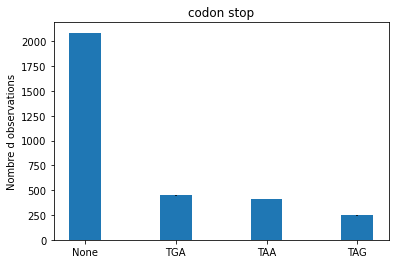

In [13]:
stpcdnStd = (1,2,3,4)
ind = np.arange(len(stop_code_freq))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, stop_code_freq, width, yerr=stpcdnStd)

plt.ylabel('Nombre d observations')
plt.title('codon stop')
plt.xticks(ind, st)

Graphique du nombre d'observations de codons stop sur l'ensemble de données

Il est intéressant d'examiner la fréquence moyenne d'occurrence de chaque nucléotide sur l'ensemble de l'ensemble de données.

In [16]:
data.median(axis = 0)

A    13.0
T    14.0
G    15.0
C    15.0
D     0.0
N     0.0
R     0.0
S     0.0
dtype: float64

Nous essaierons de déterminer la corrélation entre les données disponibles

In [17]:
data.corr()

,A,T,G,C,D,N,R,S
A,1.000000,0.021637,-0.317992,-0.587782,-0.019735,-0.031145,-0.013953,0.000192
T,0.021637,1.000000,-0.579559,-0.374532,-0.023977,-0.046278,0.018529,-0.011883
G,-0.317992,-0.579559,1.000000,-0.143892,0.030838,-0.042843,-0.012116,-0.012116
C,-0.587782,-0.374532,-0.143892,1.000000,0.005407,-0.017196,0.003823,0.019337
D,-0.019735,-0.023977,0.030838,0.005407,1.000000,-0.000601,-0.000444,-0.000444
N,-0.031145,-0.046278,-0.042843,-0.017196,-0.000601,1.000000,-0.000425,-0.000425
R,-0.013953,0.018529,-0.012116,0.003823,-0.000444,-0.000425,1.000000,-0.000314
S,0.000192,-0.011883,-0.012116,0.019337,-0.000444,-0.000425,-0.000314,1.000000


Ci-dessus, un tableau de la corrélation entre le nombre de nucléotides de chaque espèce dans l'ensemble de données.
Evaluons-le selon le tableau ci-dessous :

La valeur du coefficient de corrélation r Interprétation
- 0 < r <= 0,2   Corrélation très faible
- 0,2 < r <= 0,5  Corrélation faible
- 0,5 < r <= 0,7  Corrélation moyenne
- 0,7 < r <= 0,9  Forte corrélation
- 0,9 < r <= 1   Très forte corrélation
                        
La corrélation entre les nucléotides complémentaires est faible, et entre les nucléotides non complémentaires est moyenne, la corrélation avec les nucléotides variables est pratiquement absente
   


Graphiques montrant la corrélation dans l'ensemble de données préparé

### Data Cleanup

Tout d'abord, nous importons toutes les bibliothèques utilisées pour le pretraitement:

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from dtw import dtw
from random import choice
import os.path
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from scipy.stats import mode

df = pd.read_csv('splice.data', names = ['Class', 'Name', 'Sequence'])
df.head()

,Class,Name,Sequence
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...


Étant donné que les données d'origine peuvent avoir un espacement incohérent, nous supprimerons tout espace blanc de début ou de fin de chaque entrée.

In [29]:
df['Class'] = df['Class'].str.strip()
df['Name'] = df['Name'].str.strip()
df['Sequence'] = df['Sequence'].str.strip()

Pour les besoins de notre modèle initial, nous supprimerons toutes les instances de la classe "N" ou Ni. Cela ne laissera que les classes EI et IE pour analyse.

In [30]:
df = df[df.Class != 'N']
df['Class'].value_counts()

IE    768
EI    767
Name: Class, dtype: int64

Il y a une entrée qui contient des données incomplètes ; il peut être retiré.

In [31]:
df[df.Name == 'HUMALPI1-DONOR-42'].iloc[0, 2]
df = df[df.Name != 'HUMALPI1-DONOR-42']

'CACACAGGGCACCCCCTCANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'

La colonne "Nom" n'est pas nécessaire pour la procédure et peut être supprimée.

In [32]:
df = df.drop('Name', axis=1)
df.head()

,Class,Sequence
0,EI,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,EI,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,EI,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,EI,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,EI,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


Le mappage de EI et IE sur 0 et 1 respectivement facilite la tâche de notre classificateur par la suite.

In [34]:
df['Class'] = df['Class'].map({'EI': 0, 'IE': 1})
df.head()
df.tail()

,Class,Sequence
0,0,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...
1,0,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...
2,0,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...
3,0,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...
4,0,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...


,Class,Sequence
1530,1,AGCCTGGGCTGACCCCACGTCTGGCCACAGGCCCGCGTGCTGCCCC...
1531,1,CTGTCCTGTGGGTTCCTCTCACCCCCTCAGGCTGCTGGTCGTCTAC...
1532,1,ATGTTTAAACCTCGCGTTTCCTCCCCGCAGCTCTTGGGCAATGTGC...
1533,1,CTGTCCTGTGGGTTCCTCTCACCCTCTCAGGTTGCTGGTCGTCTAC...
1534,1,CATATGTATCTTTTTACCTTTTCCCAACAGCTCCTGGGCAACGTGC...


Il est nécessaire de coder nos nucléotides en nombres afin que leur modèle et leur ordre puissent être analysés. Les bases seront codées en 1, 2, 3 et 4 par ordre alphabétique. Les nucléotides ambigus, N, D, S et R seront choisis de manière pseudo-aléatoire, en fonction des nucléotides possibles qu'il pourrait s'agir.

In [35]:
def translateSequence(sequence):
    baseDict = {'A':'1', 'C':'2', 'G':'3', 'T':'4', 'N':choice(['1', '2', '3', '4']),
               'D':choice(['1', '3', '4']), 'S':choice(['2', '3']), 'R':choice(['1', '3'])}
    newSequence = ''
    for base in sequence:
        newSequence += baseDict[base] 
    return newSequence

df['Sequence'] = [translateSequence(sequence) for sequence in df['Sequence']]
df.head()

,Class,Sequence
0,0,2213243214212133133221323132133424344221133322...
1,0,1312223223331332331331224321333431322221223222...
2,0,3133431133123422442222133132233431311323213423...
3,0,3332432344324334212144224332133414333323333244...
4,0,3242132222213342122213311243123431343422221422...


Chaque séquence de nombres est divisée, formant une matrice. Chaque ligne de cette matrice contiendra une séquence qui a été encodée en nombres.

In [36]:
y = np.asarray(df['Class'])
np.shape(y)
X = np.asarray([list(map(int, sequence)) for sequence in df['Sequence']])
X
np.shape(X)

(1534,)

array([[2, 2, 1, ..., 2, 4, 3],
       [1, 3, 1, ..., 2, 3, 2],
       [3, 1, 3, ..., 1, 4, 3],
       ...,
       [1, 4, 3, ..., 2, 4, 3],
       [2, 4, 3, ..., 3, 1, 3],
       [2, 1, 4, ..., 2, 4, 3]])

(1534, 60)

## Dynamic Time Warping

Dynamic Time Warping est un algorithme permettant de mesurer la similarité entre deux suites qui peuvent varier au cours du temps. Nous parcourons toutes les séquences, en prenant la distance euclidienne et en calculant le score de dissemblance :

In [39]:
if os.path.exists("matrix.csv"):
    dissimMatrix = np.asarray(pd.read_csv("matrix.csv", index_col=0))
else:
    dissimMatrix = []
    for i, seq1 in enumerate(X):
        dissimMatrix.append([])
        for seq2 in X:
            euclideanDist = lambda seq1, seq2: np.abs(seq1 - seq2)
            warpScore = dtw(seq1, seq2, dist=euclideanDist)
            dissimMatrix[i].append(warpScore[0])
    pd.DataFrame(data=dissimMatrix).to_csv("matrix.csv")

Voici un exemple d'alignement de 2 séquences réalisé avec l'algorithme Dynamic Time Warping

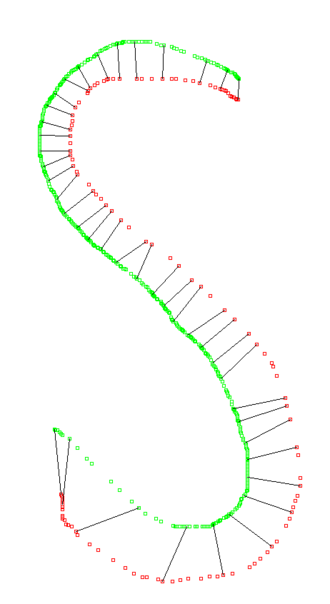

### PCA

Donc maintenant qu’on a terminé le prétraitement, on passe appliquer l'ACP

L'analyse en composantes principales nous permet de réduire la dimensionnalité de cet ensemble de données de grande dimension. Cela nous permet de tracer les données en 2 ou 3 dimensions.

In [40]:
reducedMatrix = PCA(n_components=3).fit_transform(dissimMatrix)

<IPython.core.display.Javascript object>


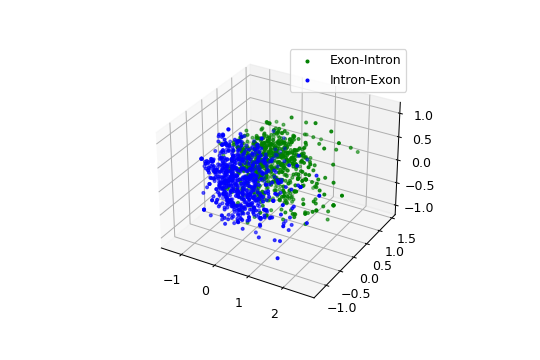

In [41]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reducedMatrix[:766, 0], reducedMatrix[:766, 1], reducedMatrix[:766, 2], marker='.', c='green')
ax.scatter(reducedMatrix[766:, 0], reducedMatrix[766:, 1], reducedMatrix[766:, 2], marker='.', c='blue')
ax.legend(['Exon-Intron', 'Intron-Exon'])
plt.show()

### K Nearest Neighbors

Enfin, notre modèle est prêt à être validé/testé. Tout d'abord, nous devons diviser l'ensemble de données en utilisant stratified k fold cross-validation

La validation croisée à k blocs, « k-fold cross-validation » : on divise l'échantillon original en k échantillons (ou « blocs »), puis on sélectionne un des k échantillons comme ensemble de validation pendant que les k-1 autres échantillons constituent l'ensemble d'apprentissage. 

Après apprentissage, on peut calculer une performance de validation. Puis on répète l'opération en sélectionnant un autre échantillon de validation parmi les blocs prédéfinis. À l'issue de la procédure nous obtenons ainsi k scores de performances, un par bloc. La moyenne et l'écart type des k scores de performances peuvent être calculés pour estimer le biais et la variance de la performance de validation.

In [42]:
def createMatrix(values, train_index, dissimMatrix):
    matrix = []
    for c, i in enumerate(values):
        matrix.append([])
        for j in train_index:
            matrix[c].append(dissimMatrix[i][j])
    return matrix

def splitData(X, y, dissimMatrix):
    skf = StratifiedKFold(n_splits=5)
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    for train_index, test_index in skf.split(X, y):
        X_train.append(createMatrix(train_index, train_index, dissimMatrix))
        X_test.append(createMatrix(test_index, train_index, dissimMatrix))
        y_train.append(y[train_index])
        y_test.append(y[test_index])
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitData(X, y, dissimMatrix)

Maintenant, nous faisons les prédictions :

In [43]:
def predictClass(X_train, X_test, y_train, y_test, k):
    y_pred = []
    metric = {'acc':[], 'conf':[], 'prec':[], 'recall':[], 'f1':[]}
    model = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
    for i, fold in enumerate(X_test):
        y_pred.append([])
        model = model.fit(X_train[i], y_train[i])
        y_pred[i] = model.predict(fold)
        pair = y_test[i], y_pred[i]
        metric['acc'].append(accuracy_score(*pair))
        metric['conf'].append(confusion_matrix(*pair).ravel())
        metric['prec'].append(precision_score(*pair))
        metric['recall'].append(recall_score(*pair))
        metric['f1'].append(f1_score(*pair))
    return metric
kMin, kMax = 1, 3
kArr = list(range(kMin, kMax + 1)) + [11, 14]
results = np.asarray([predictClass(X_train, X_test, y_train, y_test, k) for k in kArr])

Et affichons les résultats :

In [44]:
for i, k in enumerate(results):
    table = pd.DataFrame(np.asarray(list(k.values())).T, index=range(1,len(X_test) + 1),
                         columns=['Accuracy', 'Confusion Matrix', 'Precision', 'Recall', 'F1'])
    table[['TN', 'FP', 'FN', 'TP']] = pd.DataFrame(table['Confusion Matrix'].values.tolist(), index=table.index)
    table = table.drop('Confusion Matrix', axis=1)
    means = pd.DataFrame(table.iloc[:,0:4].mean(), columns=['Average']).transpose()
    table = table.append(means, sort=False)
    print('\t\t\t{}-NN'.format(kArr[i]))
    table
    print()

			1-NN


C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.824104,0.832215,0.810458,0.821192,129.0,25.0,29.0,124.0
2,0.794788,0.827338,0.746753,0.784983,129.0,24.0,39.0,115.0
3,0.81759,0.85,0.772727,0.809524,132.0,21.0,35.0,119.0
4,0.771987,0.823077,0.694805,0.753521,130.0,23.0,47.0,107.0
5,0.833333,0.849315,0.810458,0.829431,131.0,22.0,29.0,124.0
Average,0.80836,0.836389,0.76704,0.79973,NaN,NaN,NaN,NaN



			2-NN


C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.801303,0.933962,0.647059,0.764479,147.0,7.0,54.0,99.0
2,0.771987,0.881818,0.62987,0.734848,140.0,13.0,57.0,97.0
3,0.76873,0.873874,0.62987,0.732075,139.0,14.0,57.0,97.0
4,0.749186,0.942529,0.532468,0.680498,148.0,5.0,72.0,82.0
5,0.830065,0.917355,0.72549,0.810219,143.0,10.0,42.0,111.0
Average,0.784254,0.909908,0.632951,0.744424,NaN,NaN,NaN,NaN



			3-NN


C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.846906,0.901515,0.777778,0.835088,141.0,13.0,34.0,119.0
2,0.814332,0.843972,0.772727,0.80678,131.0,22.0,35.0,119.0
3,0.856678,0.857143,0.857143,0.857143,131.0,22.0,22.0,132.0
4,0.820847,0.866667,0.75974,0.809689,135.0,18.0,37.0,117.0
5,0.866013,0.873333,0.856209,0.864686,134.0,19.0,22.0,131.0
Average,0.840955,0.868526,0.804719,0.834677,NaN,NaN,NaN,NaN



			11-NN


C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.899023,0.876543,0.928105,0.901587,134.0,20.0,11.0,142.0
2,0.859935,0.849057,0.876623,0.86262,129.0,24.0,19.0,135.0
3,0.908795,0.875,0.954545,0.913043,132.0,21.0,7.0,147.0
4,0.840391,0.826087,0.863636,0.844444,125.0,28.0,21.0,133.0
5,0.895425,0.853801,0.954248,0.901235,128.0,25.0,7.0,146.0
Average,0.880714,0.856098,0.915432,0.884586,NaN,NaN,NaN,NaN



			14-NN


C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,Accuracy,Precision,Recall,F1,TN,FP,FN,TP
1,0.889251,0.883871,0.895425,0.88961,136.0,18.0,16.0,137.0
2,0.869707,0.865385,0.876623,0.870968,132.0,21.0,19.0,135.0
3,0.921824,0.891566,0.961039,0.925,135.0,18.0,6.0,148.0
4,0.85342,0.856209,0.850649,0.85342,131.0,22.0,23.0,131.0
5,0.895425,0.866667,0.934641,0.899371,131.0,22.0,10.0,143.0
Average,0.885925,0.87274,0.903675,0.887674,NaN,NaN,NaN,NaN


Dans ce contexte:
* Un vrai négatif signifie qu'un EI a été correctement identifié comme EI
* Un faux positif signifie qu'un EI a été incorrectement identifié comme IE
* Un faux négatif signifie qu'un IE a été incorrectement identifié comme EI
* Un vrai positif signifie qu'un IE a été correctement identifié comme IE

### SVM

On passe à la construction de notre modèle on utilisant l’SVM. Après avoir visualiser les données par l’ACP, on a bien remarqué que les données sont non lineairement séparable, donc on utilisé le support vector machines non linéaire. On a essayé d’utiliser le kernel rbf , et donc pour les hyperparamètres C et gamma on a utilisé le cross validation avec le grid search. On a obtenu les hyperparametres optimaux : un C qui est égal à 3 et gamma = 0.002. Et donc on a appliqué le svm avec ces hyperparamètres et on a obtenu un score de test égale à 96%

In [82]:
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [83]:
# read in data
filename = "splice.data"
rawData = np.loadtxt(filename, dtype=np.str, converters = {0: lambda s: s[0:-1]}, usecols=(0, 2))

<ipython-input-83-ae2e9ec91b08>:3: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rawData = np.loadtxt(filename, dtype=np.str, converters = {0: lambda s: s[0:-1]}, usecols=(0, 2))


In [84]:
# parse data (and set up one-hot encoding)
basesToValues = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'D': [0.3, 0, 0.3, 0.3], 'N': [0.25, 0.25, 0.25, 0.25], 'S': [0, 0.5, 0.5, 0], 'R': [0.5, 0, 0.5, 0]}
data = np.zeros((len(rawData), 60*4))
labels = np.zeros((len(rawData))).astype('S')
for r in range(0, len(rawData)):
    labels[r] = rawData[r][0]
    bases = list(rawData[r][1])
    baseData = np.array(basesToValues[bases[0]])
    for i in range(1, 60):
        baseData = np.append(baseData, basesToValues[bases[i]])
    data[r] = baseData

data = StandardScaler().fit_transform(data)  # normalize data to have mean 0 and variance 1

In [1]:
def svc_param_selection_rbf(X, y, nfolds):
    #this is the slack penalty hyperparameter
    Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
    #gamma parameter which inversely controls the standard deviation of our kernel's distributio
    gammas = [0.001, 0.01, 0.1, 1, 10, 100]
    #initialize the dictionary of parameters
    param_grid = {'C': Cs, 'gamma' : gammas}
    #initialize the search using input as nfold cross validation
    search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds)
    #fit the search object to our input training data
    search.fit(X, y)
    #output the best parameters
    search.best_params_
    return search.best_params_

Grid Search est une méthode d'optimisation (hyperparameter optimization) qui va nous permettre de tester une série de paramètres et de comparer les performances pour en déduire le meilleur paramétrage

In [85]:
# train model & generate predictions
classifier = svm.SVC(C=3.0, gamma=0.002, random_state=42)  # find parameters using hyperparameter tuning
trainData, testData, trainLabels, testLabels = train_test_split(data, labels, test_size = 0.5, shuffle = True, random_state=42)
classifier.fit(trainData, trainLabels)
predicted = classifier.predict(testData)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(testLabels, predicted)))

SVC(C=3.0, gamma=0.002, random_state=42)

Classification report for classifier SVC(C=3.0, gamma=0.002, random_state=42):
              precision    recall  f1-score   support

       b'EI'       0.95      0.95      0.95       395
       b'IE'       0.93      0.94      0.93       387
        b'N'       0.97      0.97      0.97       813

    accuracy                           0.96      1595
   macro avg       0.95      0.95      0.95      1595
weighted avg       0.96      0.96      0.96      1595




C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 0.98, 'Confusion Matrix')

Confusion matrix:
[[377  15   3]
 [  4 364  19]
 [ 15  13 785]]


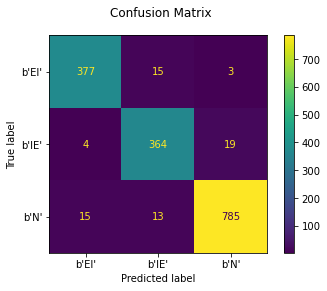

In [86]:
# display confusion matrix
disp = metrics.plot_confusion_matrix(classifier, testData, testLabels)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)